In [1]:
library(ggplot2)
library(caret)
library(leaps)
library(MASS)  # used for stepAIC
library(glmnet)


data <- read.csv("../data/Devices.csv")
data$Gender <- as.factor(data$Gender)
data$Activity <- as.factor(data$Activity)
data$Device <- as.factor(data$Device)

# Performing Best Subset Selection
subset_fit <- regsubsets(Heart ~ ., data = data, nbest = 1, nvmax = NULL, method = "exhaustive")
summary(subset_fit)

Loading required package: lattice

Loading required package: Matrix

Loaded glmnet 4.1-8



Subset selection object
Call: regsubsets.formula(Heart ~ ., data = data, nbest = 1, nvmax = NULL, 
    method = "exhaustive")
13 Variables  (and intercept)
                    Forced in Forced out
X                       FALSE      FALSE
Calories                FALSE      FALSE
Steps                   FALSE      FALSE
Distance                FALSE      FALSE
Age                     FALSE      FALSE
GenderM                 FALSE      FALSE
Weight                  FALSE      FALSE
Height                  FALSE      FALSE
Activity1.Sedentary     FALSE      FALSE
Activity2.Light         FALSE      FALSE
Activity3.Moderate      FALSE      FALSE
Activity4.Vigorous      FALSE      FALSE
DeviceFitbit            FALSE      FALSE
1 subsets of each size up to 13
Selection Algorithm: exhaustive
          X   Calories Steps Distance Age GenderM Weight Height
1  ( 1 )  " " "*"      " "   " "      " " " "     " "    " "   
2  ( 1 )  " " "*"      " "   " "      " " "*"     " "    " "   
3  ( 1 )  " " 

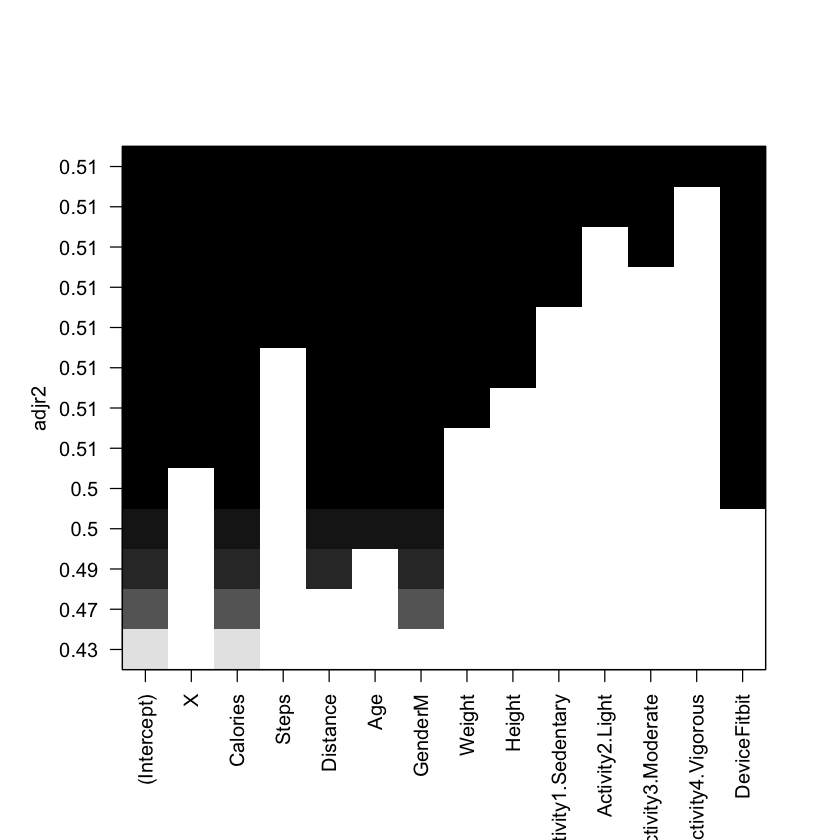

In [2]:
# subset selection results
plot(subset_fit, scale = "adjr2")

In [3]:
# GLM with stepwise selection using AIC and including the interaction effect
full_model <- glm(Heart ~ . + Device:Activity, data = data, family = gaussian())
step_model <- stepAIC(full_model, direction = "both")
summary(step_model)

Start:  AIC=621214.2
Heart ~ X + Calories + Steps + Distance + Age + Gender + Weight + 
    Height + Activity + Device + Device:Activity

                  Df Deviance    AIC
<none>               12465618 621214
- Steps            1 12474940 621271
- Height           1 12483601 621325
- Activity:Device  4 12492421 621375
- Weight           1 12510629 621495
- Distance         1 12526841 621597
- Age              1 12606052 622093
- X                1 12638789 622296
- Gender           1 13256361 626045
- Calories         1 14705805 634200



Call:
glm(formula = Heart ~ X + Calories + Steps + Distance + Age + 
    Gender + Weight + Height + Activity + Device + Device:Activity, 
    family = gaussian(), data = data)

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       7.668e+01  1.123e+00  68.272  < 2e-16 ***
X                                -1.251e-04  3.787e-06 -33.037  < 2e-16 ***
Calories                          6.111e+00  5.143e-02 118.825  < 2e-16 ***
Steps                             3.044e-02  3.971e-03   7.665 1.81e-14 ***
Distance                          8.845e-02  4.503e-03  19.644  < 2e-16 ***
Age                               2.685e-01  9.026e-03  29.751  < 2e-16 ***
GenderM                          -9.014e+00  1.277e-01 -70.597  < 2e-16 ***
Weight                            3.263e-02  1.937e-03  16.843  < 2e-16 ***
Height                           -2.349e+00  2.206e-01 -10.646  < 2e-16 ***
Activity1.Sedentary              -1.034e+00  1.1

In [12]:
# Stratified K-fold Cross-Validation to ensure  that each fold is a good representative of the whole dataset
set.seed(83)
folds <- createFolds(data$Heart, k = 10, list = TRUE, returnTrain = TRUE)
cv_results <- lapply(folds, function(x) {
  train_set <- data[x,]
  test_set <- data[-x,]
  fit <- glm(Heart ~ . + Device:Activity, data = train_set, family = gaussian())
  predicted <- predict(fit, newdata = test_set)
  actual <- test_set$Heart
  mse <- mean((predicted - actual)^2)
  residuals <- actual - predicted
  return(list(MSE = mse, residuals = residuals, predicted = predicted))
})

In [13]:
# getting more metrics
mse_values <- unlist(lapply(cv_results, function(x) x$MSE))
rmse <- sqrt(mean(mse_values))  # Root Mean Squared Error
mae <- mean(unlist(lapply(cv_results, function(x) abs(x$residuals))))  

cat("RMSE:", rmse, "\n")
cat("MAE:", mae, "\n")

RMSE: 12.60002 
MAE: 9.260575 


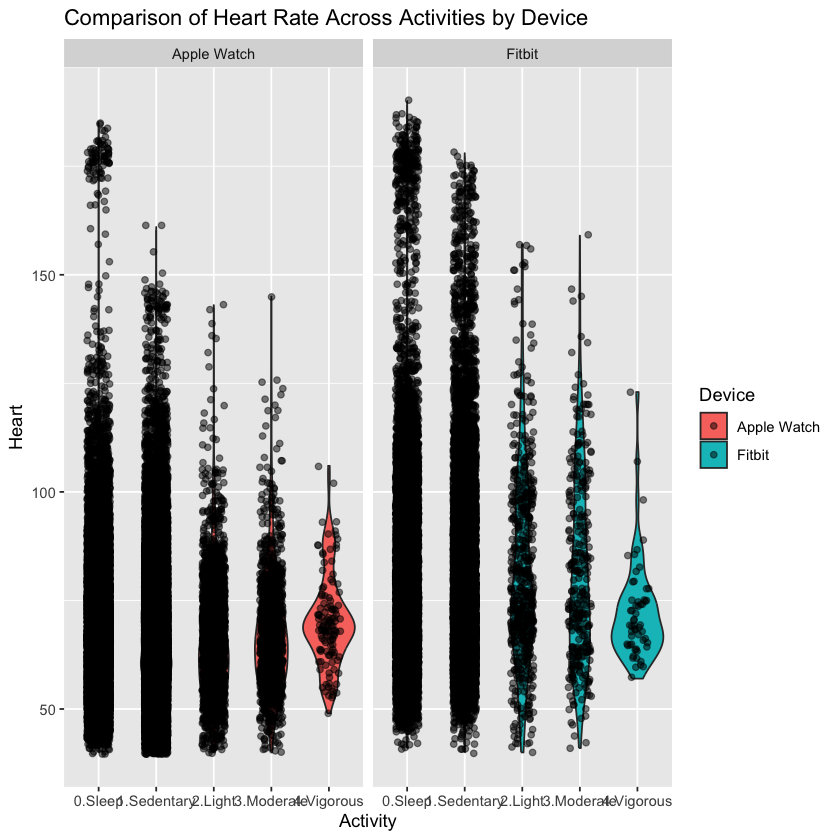

In [14]:
# showing impact of devices
ggplot(data, aes(x = Activity, y = Heart, fill = Device)) +
  geom_violin() +
  geom_jitter(width = 0.2, alpha = 0.5) +
  facet_wrap(~Device) +
  labs(title = "Comparison of Heart Rate Across Activities by Device")

`geom_smooth()` using formula = 'y ~ x'


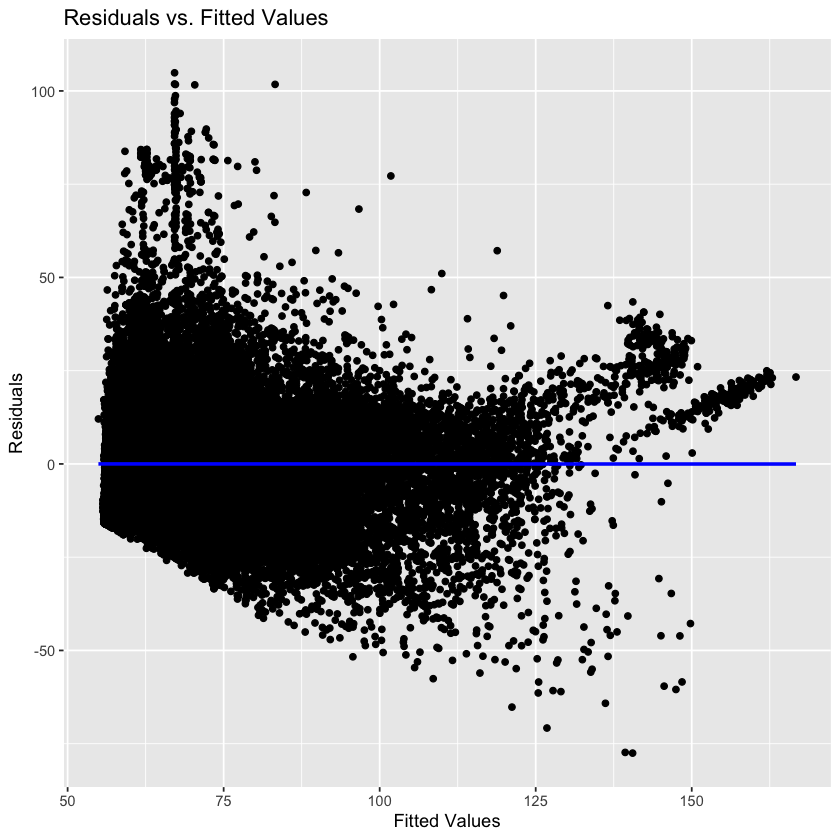

In [15]:
predicted_values <- unlist(lapply(cv_results, function(x) x$predicted))
residuals_values <- unlist(lapply(cv_results, function(x) x$residuals))
residuals_data <- data.frame(Residuals = residuals_values, Fitted = predicted_values)

ggplot(residuals_data, aes(x = Fitted, y = Residuals)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "blue") +
  labs(title = "Residuals vs. Fitted Values", x = "Fitted Values", y = "Residuals")

`geom_smooth()` using formula = 'y ~ x'


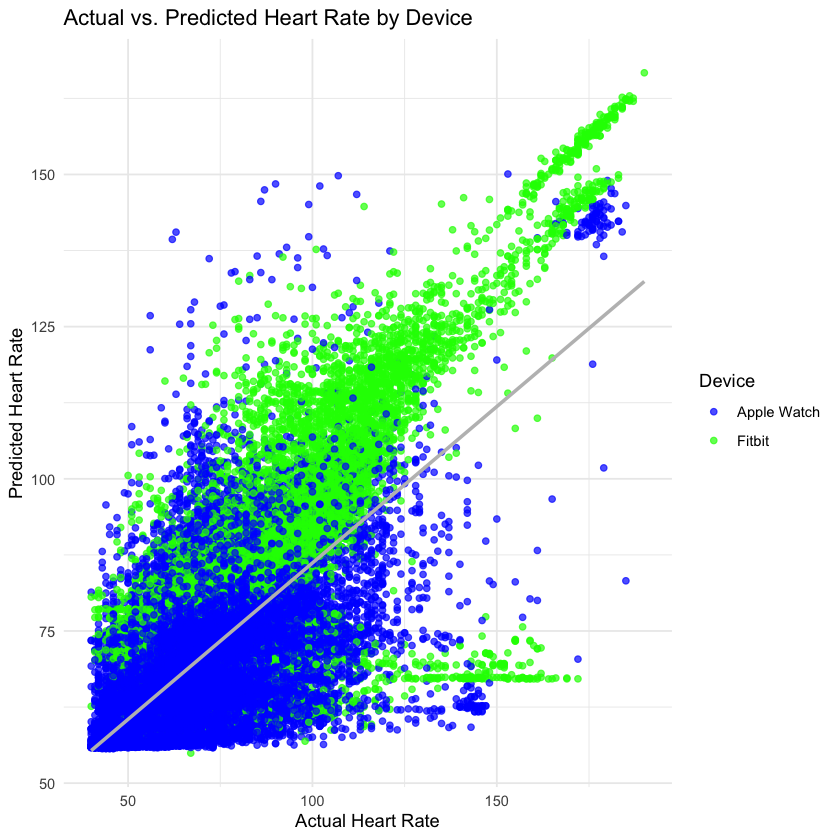

In [11]:
all_results <- do.call(rbind, cv_results)

# Plot Actual vs. Predicted Heart Rate colored by Device
ggplot(all_results, aes(x = Actual, y = Predicted, color = Device)) +
  geom_point(alpha = 0.7) +
  geom_smooth(method = "lm", se = FALSE, color = "gray") +  # Add a trend line for overall trend
  labs(title = "Actual vs. Predicted Heart Rate by Device",
       x = "Actual Heart Rate",
       y = "Predicted Heart Rate") +
  theme_minimal() +
  scale_color_manual(values = c("Apple Watch" = "blue", "Fitbit" = "green")) 